In [1]:
#***********************************#
#                                   #
#             Packages              #        
#                                   #
#***********************************#

import csv
import allantools as allan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import allantools as AT

In [5]:
#***********************************#
#                                   #
#             Constants             #        
#                                   #
#***********************************#



#T_clk = 4*10**-7
adc_clk = 512 * 10 ** 6
T_adc = 1/(adc_clk)
#adc_clk = 2.5 * 10 ** 7
fpga_clk = 250 * 10 ** 6
#fpga_clk = 250 * 10 ** 4
FFT_length = 1024
#FFT_length = 256
run_time = 0.0596046448
# for testing, consider a 100 MHz source
source_freq = 100 * 10 ** 6 
square_freq = 100 * 10 ** 3
#source_freq = 0.55

In [6]:
#***********************************#
#                                   #
#            Functions              #        
#                                   #
#***********************************#

def real_wave(amp, freq, time):
    omega = 2 * np.pi * freq    
    wave = amp*np.cos(omega * time)
    return wave

def real_mix(wave_1, wave_2):
    mix_wave = wave_1 * wave_2
    return mix_wave
    
def fft(signal):
    spectrum = np.fft.fft(signal, n = FFT_length)
    return spectrum

def noisify(signal):
    w_noise = np.random.normal(0, .1, signal.shape)
    noisy_spec = signal * w_noise
    return noisy_spec

def GET_TO_DA_CHOPPAH(signal, timespace):
    sq_wave = 0.5 * (sig.square(2 * np.pi * square_freq * timespace) + 1)
    chopped_wave = real_mix(signal, sq_wave)
    return chopped_wave

In [7]:
#***********************************#
#                                   #
#           Creating Time           #        
#                                   #
#***********************************#

###########################
#     Make FFT Frames     #
###########################

    ##### for a 1024 pt FFT, one FFT frame will take 1024/adc_clk (seconds) ##### 

# frame time = Time for 1 FFT to populate

frame_time = FFT_length / (adc_clk)

##### The number of fft frames to be created equals the                        #
    #     run time of the test over the amount of time it takes to FFT a frame #####

# ratio = number of FFT frames created over run time

ratio = int(run_time/frame_time)
frame_times = np.zeros(ratio)

##### Create an array with the times of the FFT frames #####

for i in range (ratio):                                 
    
    frame_times[i] = i * frame_time
    
    ##### Create an array of times that will be used to create the "pieces" of the wave #####

timespace = np.zeros((ratio-1, FFT_length))

    ##### Populate time array with lengths to be used later #####

for i in range(ratio-1):
    
    timespace[i] = np.linspace(frame_times[i], frame_times[i+1], FFT_length)

    ##### Make an array to store FFT frames #####
    
# Now create array which contains frequency span of FFT
n = 1024
# print(i_mix.size)
timestep = 1/adc_clk
# note this value comes from the linspace used for the time array. length/number of samples
fft_freq = np.fft.fftfreq(n, d=timestep)

fft_frames = np.zeros((ratio, FFT_length), dtype = complex)

C:\Users\hohjo\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


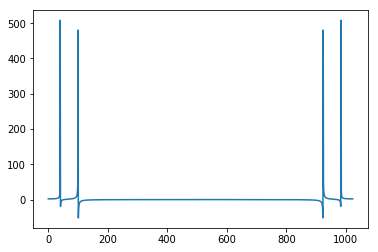

In [8]:
sig1 = real_wave(1, 20 * 10 ** 6, timespace)
sig2 = real_wave(1, 50 * 10 ** 6, timespace)
comb = sig1 + sig2
plt.plot(fft(comb[10]))



In [9]:
## Simulating the hoh_spec firmware ##

accum_len = 2 ** 23    

# create white noise equivalent to what is used in tests
signal = np.zeros(np.shape(timespace))
for i in range(ratio-1):
    signal[i] = allan.noise.white(FFT_length, 0.1, adc_clk) #create large array of white noise

# Now put the noise signal through PFB
spectra = fft(signal)

#t_streams = np.zeros((FFT_length, ratio-1), dtype=complex)
#print(np.shape(t_streams))

##### Slice and dice array to convert frames into time streams #####
t_streams = np.transpose(spectra)

# Now take the intensity of each of the time streams
t_mags = np.real(t_streams)**2 + np.imag(t_streams)**2





In [10]:
np.shape(t_mags)

(1024, 29801)

In [11]:
ratio

29802

In [12]:
frame_time

2e-06